<a href="https://colab.research.google.com/github/aaronbbarclay/mine/blob/master/DensePose_RCNN_Texture_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture Transfer Using Estimated Dense Coordinates

In this notebook we demonstrate how the estimated dense coordinates can be used to map a texture from the UV space to image pixels. For this purpose we provide an "atlas" texture space, which allows easy design of custom textures. We also provide a modified texture that is obtained from the [SURREAL](https://www.di.ens.fr/willow/research/surreal/data/) dataset, which allows replication of the qualitative results that we provide in the paper.

Let's first visualize the UV atlas space with examplar textures:

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [29]:
!mkdir -p /content/data/
%cd /content/data
!cp /content/drive/My\ Drive/MachineLearning/projects/densePose_vid2_reorgnised/*png densePose_vid2_reorgnised

/content/data


In [30]:
%cd /content/data/densePose_vid2_reorgnised/
%ls

/content/data/densePose_vid2_reorgnised
3-life-lessons-from-arnie-for-foreigners.jpg  nuke_test_v1.nknc.autosave
IMG_0357.mp4                                  PDF/
IMG_1369.mp4                                  SAVE/
INDS/                                         texture_atlas_200.png
IUV/                                          texture_atlas.png
nuke_test_v1.nknc                             vid2_src/


True


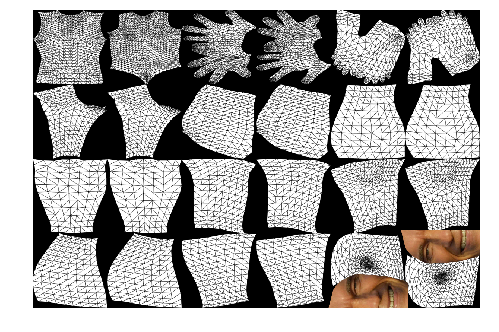

In [43]:
import numpy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

print(os.path.isfile('/content/data/densePose_vid2_reorgnised/texture_atlas_200.png'))

fig = plt.figure(figsize=[8,8])
img = cv2.imread('/content/data/densePose_vid2_reorgnised/texture_atlas_200.png')
#print(type(img))
#print(img[:,:,::-1])

TEXTURE = '/content/data/densePose_vid2_reorgnised/texture_atlas.png'

Tex_Atlas = cv2.imread(TEXTURE)[:,:,::-1]/255.
plt.imshow(Tex_Atlas.transpose([1,0,2]))
plt.axis('off')
plt.show()
#
TextureIm  = np.zeros([24,200,200,3]);
#
for i in range(4):
    for j in range(6):
        TextureIm[(6*i+j) , :,:,:] = Tex_Atlas[ (200*j):(200*j+200)  , (200*i):(200*i+200) ,: ]

The texture above is obtained from the textures provided in the [SURREAL](https://www.di.ens.fr/willow/research/surreal/data/) dataset. 

One can basically design their own textures on the provided texture images. We provide the white surface and black edges as the texture atlas guide, which is visualized below.

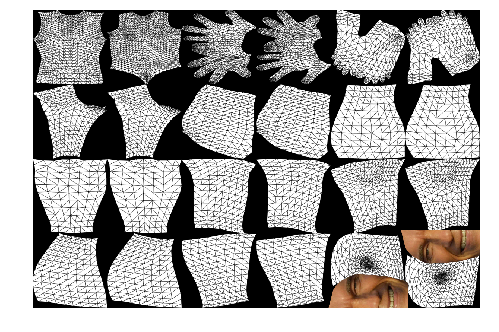

In [44]:
fig = plt.figure(figsize=[8,8])
Tex_Atlas = cv2.imread(TEXTURE)[:,:,::-1]
plt.imshow(Tex_Atlas.transpose([1,0,2]))
plt.axis('off')
plt.show()

Herein, we define the function to transfer the texture to the image domain.

In [0]:
def TransferTexture(TextureIm,im,IUV):
    U = IUV[:,:,1]
    V = IUV[:,:,2]
    #
    R_im = np.zeros(U.shape)
    G_im = np.zeros(U.shape)
    B_im = np.zeros(U.shape)
    ###
    for PartInd in range(1,25):    ## Set to xrange(1,23) to ignore the face part.
        tex = TextureIm[PartInd-1,:,:,:].squeeze() # get texture for each part.
        #####
        R = tex[:,:,0]
        G = tex[:,:,1]
        B = tex[:,:,2]
        ###############
        x,y = np.where(IUV[:,:,0]==PartInd)
        u_current_points = U[x,y]   #  Pixels that belong to this specific part.
        v_current_points = V[x,y]
        ##
        r_current_points = R[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        g_current_points = G[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        b_current_points = B[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        ##  Get the RGB values from the texture images.
        R_im[IUV[:,:,0]==PartInd] = r_current_points
        G_im[IUV[:,:,0]==PartInd] = g_current_points
        B_im[IUV[:,:,0]==PartInd] = b_current_points
    generated_image = np.concatenate((B_im[:,:,np.newaxis],G_im[:,:,np.newaxis],R_im[:,:,np.newaxis]), axis =2 ).astype(np.uint8)
    BG_MASK = generated_image==0
    generated_image[BG_MASK] = im[BG_MASK]  ## Set the BG as the old image.
    return generated_image

Let's read an IUV file obtained by rendering the SMPL model and transfer the texture!

In [0]:
%cd /content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00001_IUV.png 
%ls


['/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00001_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00002_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00003_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00004_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00005_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00006_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00007_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00008_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00009_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00010_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00011_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00012_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00013_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV//IMG_1369_00014_IUV.png', '/con

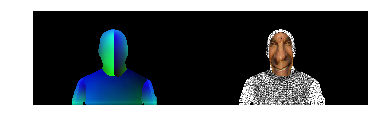

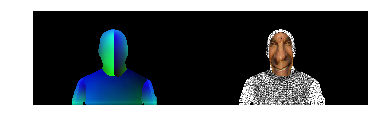

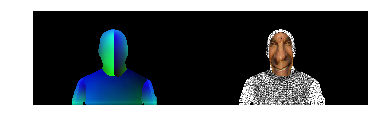

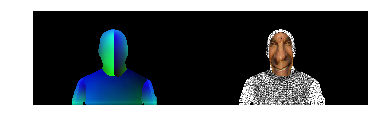

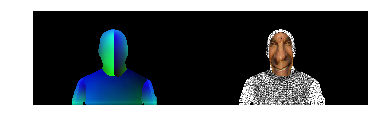

In [63]:
iuvPath = "/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00001_IUV.png" 
iuv_BASEPATH = "/content/data/densePose_vid2_reorgnised/IUV/"
allFiles = ["{0}/{1}".format(iuv_BASEPATH, x) for x in os.listdir(iuv_BASEPATH)]
allFiles.sort()
print(allFiles)

for f in allFiles[200:205]:
    #print(os.path.isfile(f))
    IUV = cv2.imread(iuvPath)
    im  = np.zeros(IUV.shape)

    image = TransferTexture(TextureIm,im,IUV)

    plt.imshow( np.hstack((IUV,image[:,:,::-1])))
    plt.axis('off')
    plt.show()

In [51]:
for x in xrange([1,2,3,4]):
    print(x)

NameError: ignored

['/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00001_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00002_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00003_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00004_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00005_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00006_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00007_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00008_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00009_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00010_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00011_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00012_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00013_IUV.png', '/content/data/densePose_vid2_reorgnised/IUV/IMG_1369_00014_IUV.png', '/content/data/dens

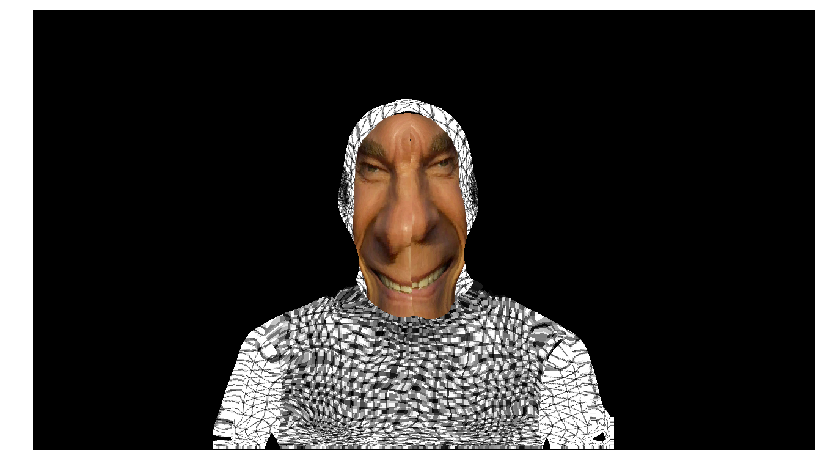

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00002_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00002_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00003_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00003_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00004_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00004_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00005_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00005_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00006_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00006_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00007_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00007_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00008_b

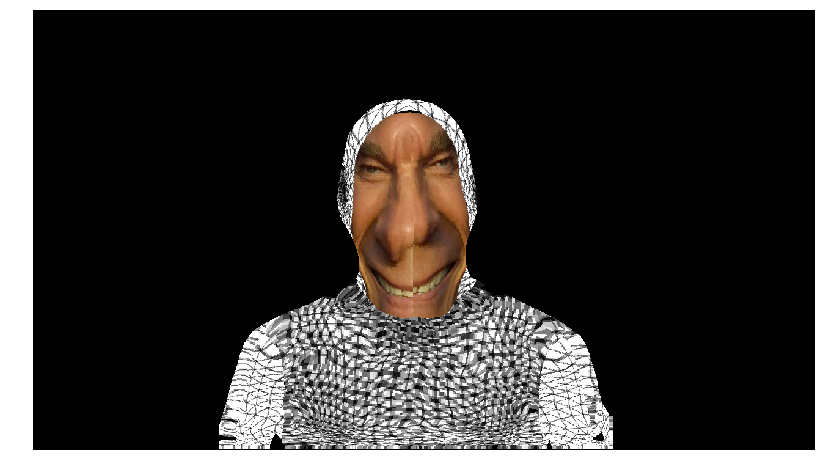

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00022_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00022_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00023_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00023_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00024_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00024_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00025_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00025_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00026_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00026_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00027_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00027_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00028_b

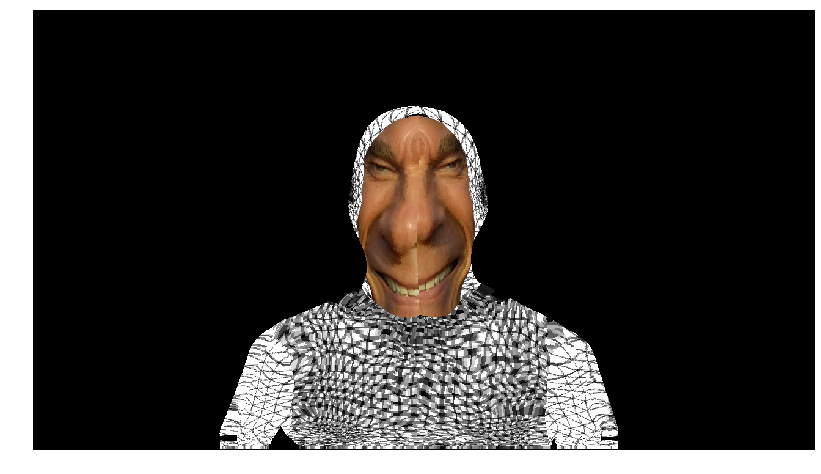

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00042_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00042_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00043_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00043_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00044_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00044_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00045_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00045_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00046_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00046_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00047_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00047_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00048_b

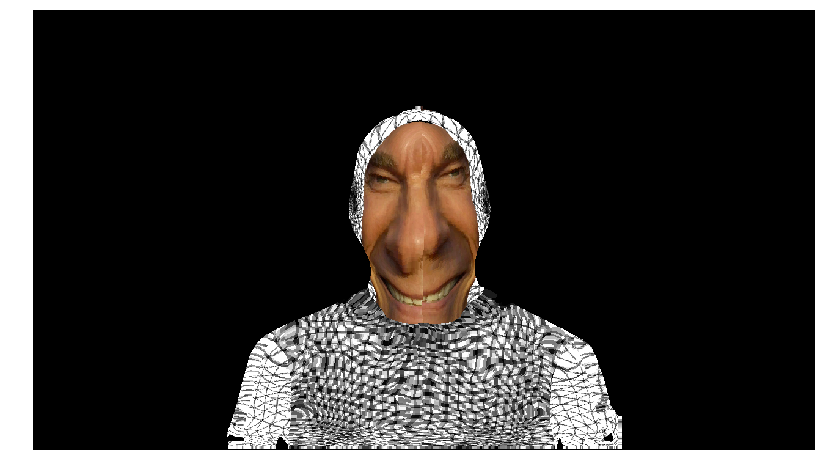

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00062_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00062_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00063_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00063_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00064_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00064_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00065_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00065_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00066_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00066_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00067_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00067_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00068_b

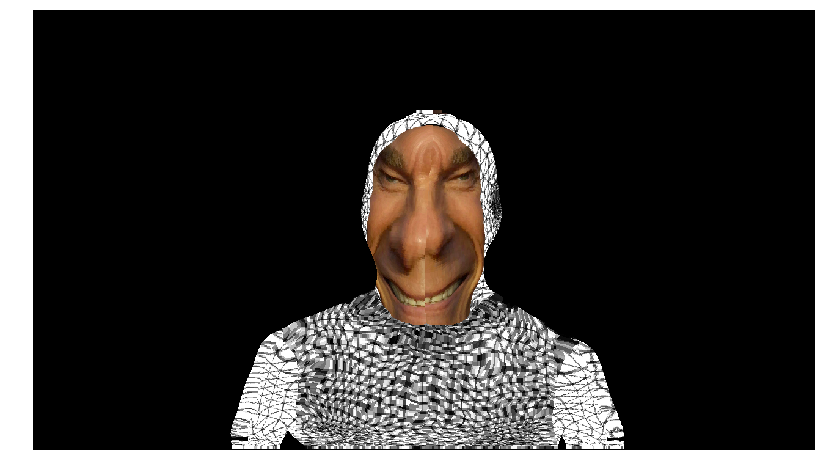

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00082_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00082_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00083_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00083_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00084_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00084_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00085_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00085_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00086_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00086_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00087_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00087_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00088_b

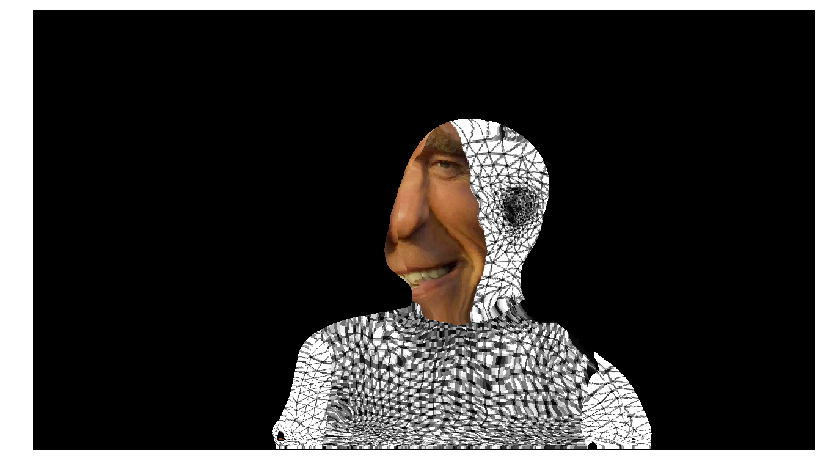

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00102_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00102_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00103_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00103_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00104_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00104_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00105_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00105_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00106_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00106_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00107_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00107_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00108_b

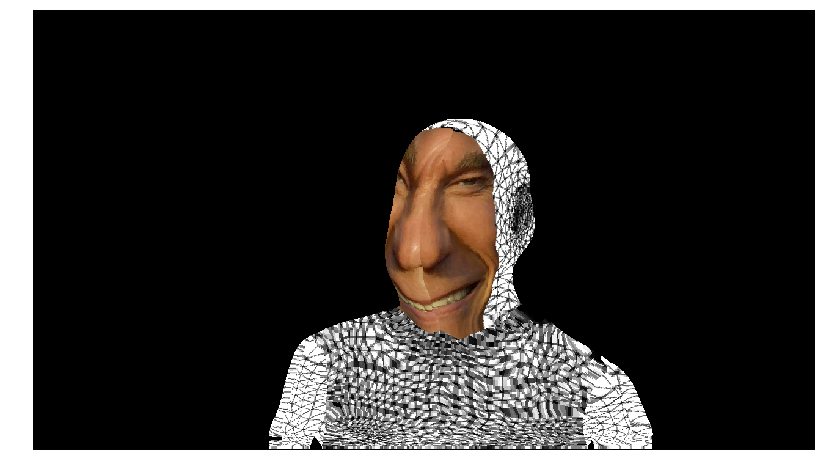

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00122_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00122_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00123_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00123_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00124_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00124_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00125_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00125_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00126_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00126_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00127_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00127_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00128_b

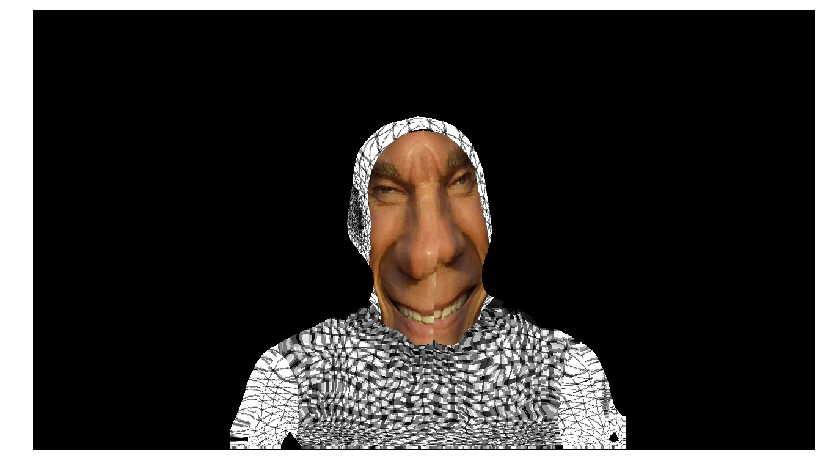

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00142_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00142_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00143_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00143_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00144_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00144_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00145_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00145_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00146_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00146_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00147_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00147_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00148_b

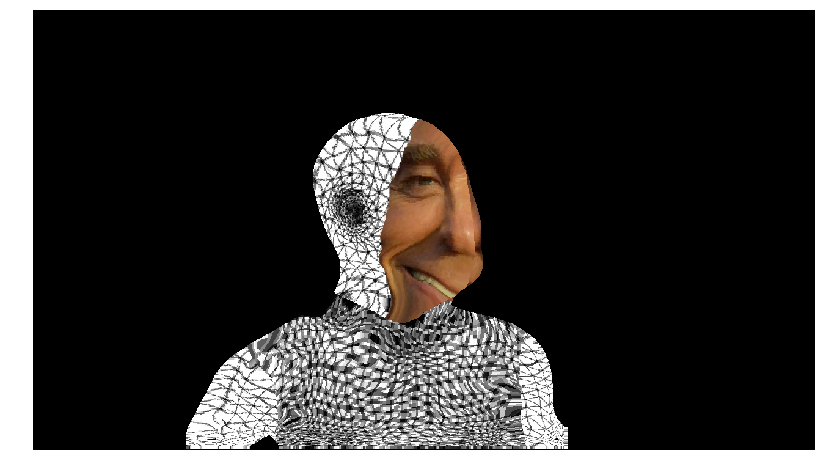

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00162_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00162_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00163_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00163_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00164_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00164_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00165_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00165_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00166_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00166_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00167_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00167_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00168_b

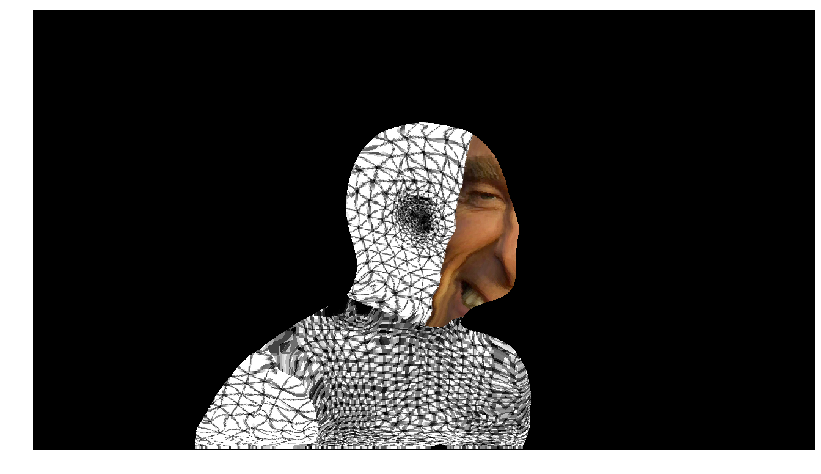

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00182_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00182_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00183_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00183_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00184_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00184_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00185_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00185_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00186_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00186_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00187_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00187_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00188_b

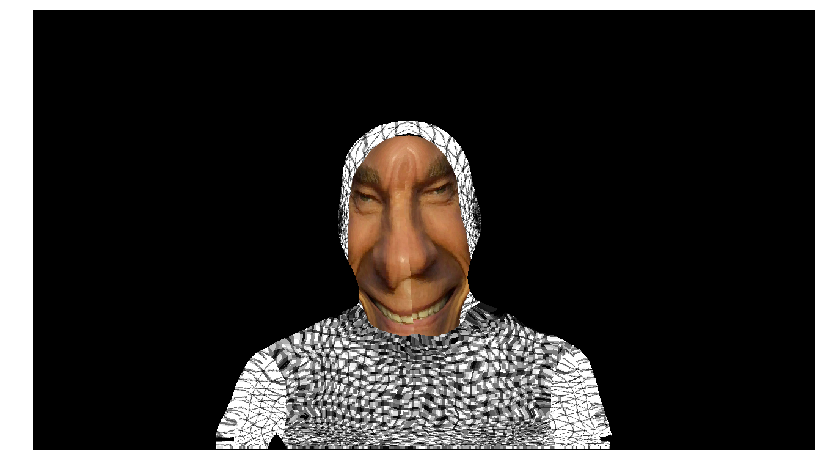

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00202_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00202_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00203_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00203_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00204_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00204_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00205_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00205_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00206_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00206_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00207_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00207_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00208_b

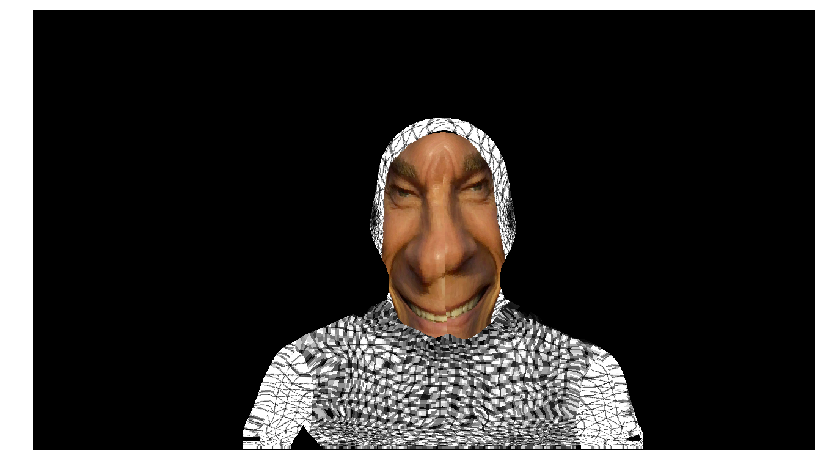

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00222_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00222_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00223_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00223_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00224_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00224_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00225_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00225_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00226_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00226_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00227_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00227_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00228_b

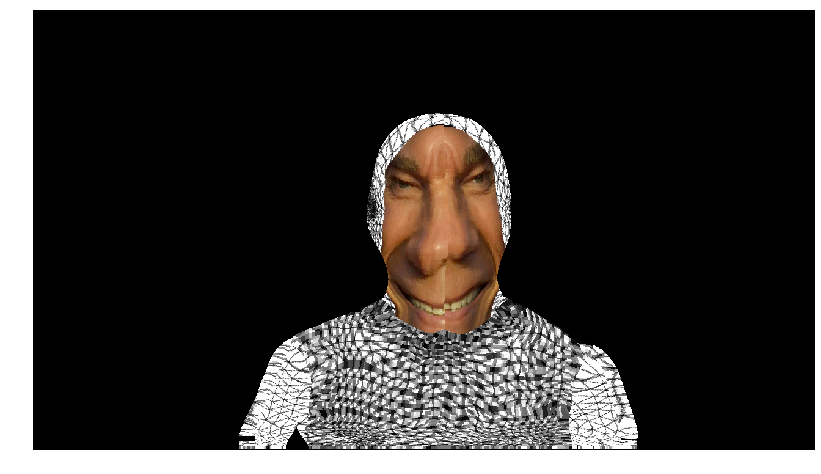

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00242_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00242_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00243_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00243_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00244_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00244_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00245_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00245_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00246_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00246_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00247_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00247_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00248_b

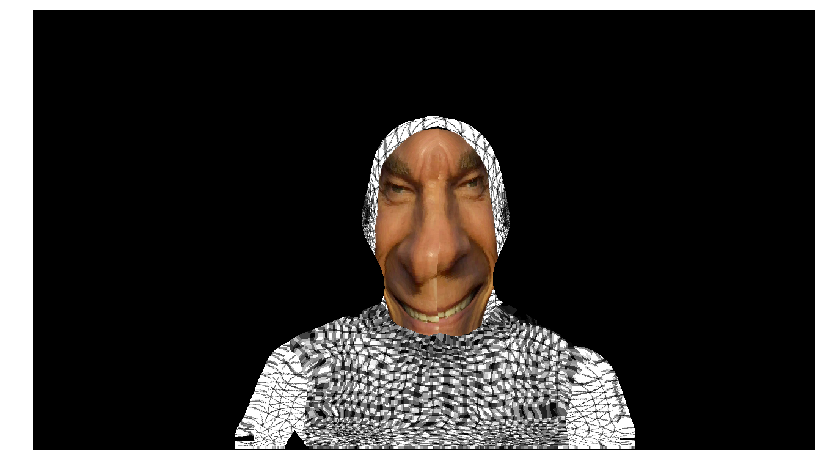

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00262_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00262_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00263_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00263_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00264_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00264_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00265_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00265_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00266_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00266_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00267_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00267_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00268_b

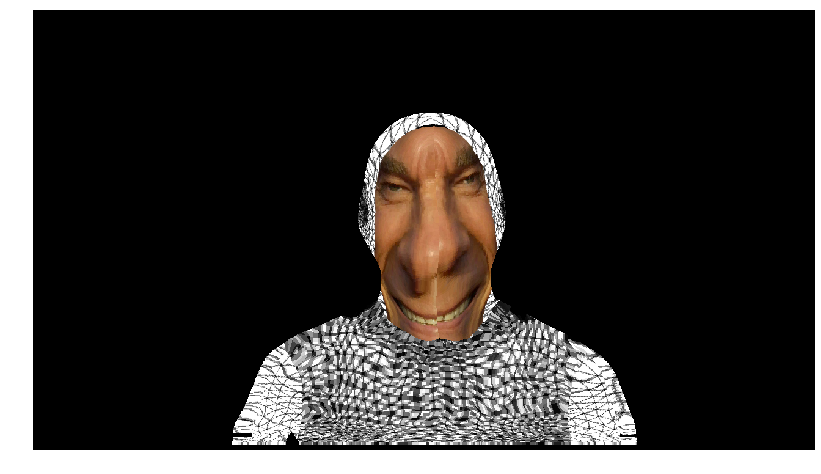

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00282_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00282_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00283_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00283_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00284_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00284_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00285_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00285_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00286_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00286_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00287_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00287_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00288_b

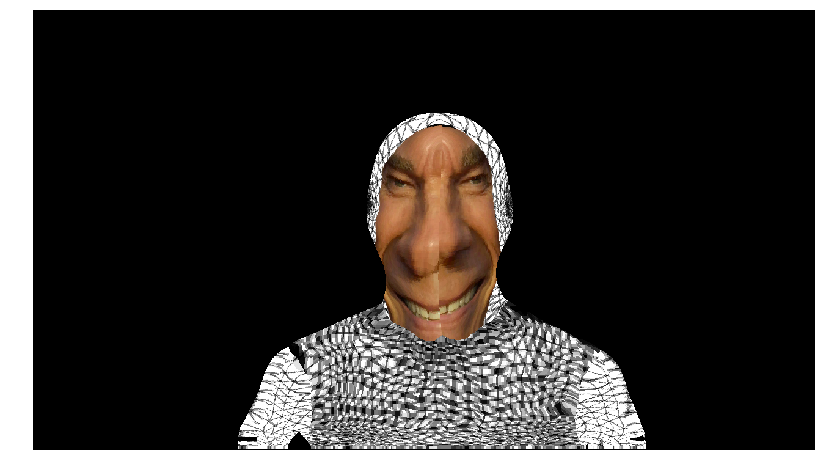

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00302_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00302_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00303_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00303_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00304_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00304_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00305_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00305_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00306_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00306_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00307_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00307_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00308_b

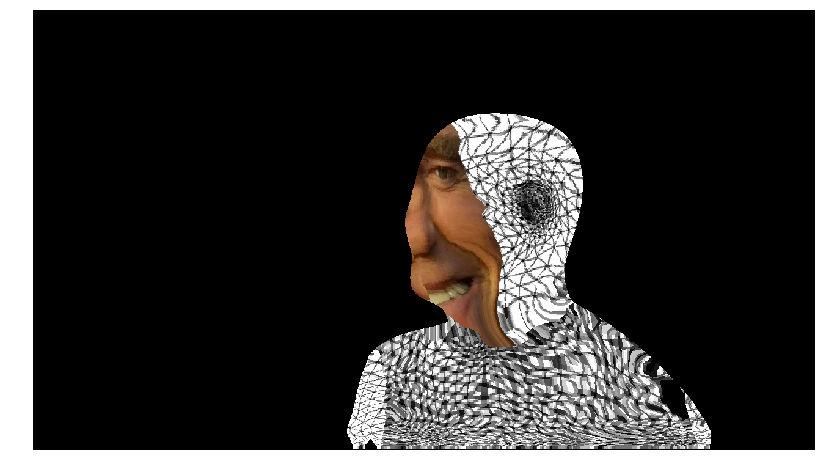

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00322_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00322_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00323_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00323_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00324_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00324_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00325_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00325_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00326_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00326_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00327_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00327_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00328_b

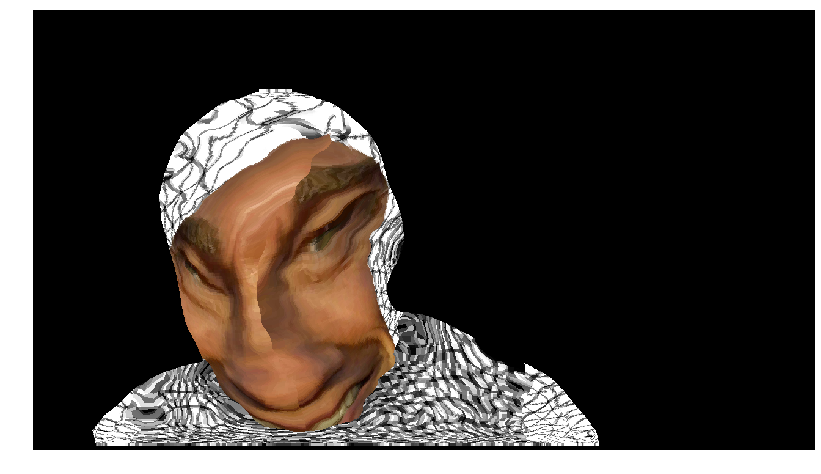

/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00342_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00342_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00343_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00343_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00344_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00344_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00345_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00345_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00346_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00346_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00347_black.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00347_bg.png
/content/data/densePose_vid2_reorgnised/text_transfer/IMG_1369_00348_b

In [115]:
import os.path
from PIL import Image
import numpy
import re

!mkdir -p "/content/data/densePose_vid2_reorgnised/text_transfer"
src_BASEPATH = "/content/data/densePose_vid2_reorgnised/vid2_src"
iuv_BASEPATH = "/content/data/densePose_vid2_reorgnised/IUV"
img_BASEPATH = "/content/data/densePose_vid2_reorgnised/SAVE"
tex_BASEPATH = "/content/data/densePose_vid2_reorgnised/text_transfer"

iuv_allFiles = ["{0}/{1}".format(iuv_BASEPATH, x) for x in os.listdir(iuv_BASEPATH)]
img_allFiles = ["{0}/{1}".format(img_BASEPATH, x) for x in os.listdir(img_BASEPATH)]
src_allFiles = ["{0}/{1}".format(src_BASEPATH, x) for x in os.listdir(src_BASEPATH)]

iuv_allFiles.sort()
img_allFiles.sort()
src_allFiles.sort()

print(iuv_allFiles)
print(img_allFiles)

i = 0
for iuvFile, imgFile, srcFile in zip(iuv_allFiles, img_allFiles, src_allFiles):
    IUV = cv2.imread(iuvFile)
    img = cv2.imread(imgFile)
    src = cv2.imread(srcFile)
    
    saveFilenameBlack = imgFile.replace("SAVE", "text_transfer").replace("save", "black")
    
    saveFilenameBG = imgFile.replace("SAVE", "text_transfer").replace("save", "bg")
    
    print(saveFilenameBlack)
    print(saveFilenameBG)
    image = TransferTexture(TextureIm, np.zeros(IUV.shape), IUV)
    image2 = TransferTexture(TextureIm, src, IUV)
    
    imgToSave = Image.fromarray(image, 'RGB')
    img2ToSave = Image.fromarray(image2, 'RGB')
    imgToSave.save(saveFilenameBlack)
    img2ToSave.save(saveFilenameBG)
    
    if i%20 == 0:
        #print(iuvFile)
        print(saveFilenameBlack)
        fig = plt.figure(figsize=[14,14])
        plt.imshow(image[:,:,::-1])
        plt.axis('off')
        plt.show()

    i += 1
           
    

In [0]:
%cd /content/data/densePose_vid2_reorgnised/text_transfer/
%ls

In [0]:
tex_BASEPATH = "/content/data/densePose_vid2_reorgnised/text_transfer"

tex_allFiles = ["{0}/{1}".format(tex_BASEPATH, x) for x in os.listdir(tex_BASEPATH)]
tex_allFiles.sort()

i = 0
for tex in tex_allFiles[:160]:
    if i%20 == 0:
        print(tex)
        tex = cv2.imread(tex)
        fig = plt.figure(figsize=[14,14])
        plt.imshow(tex[:,:,::-1])
        plt.axis('off')
        plt.show()
        
    i += 1

In [116]:
%cd /content/data/densePose_vid2_reorgnised/text_transfer/

!ffmpeg -y -r 25 -f image2 -i IMG_1369_%05d_black.png -vcodec libx264 -crf 5 -pix_fmt yuv420p IMG_1369_texttransfer_black_bg.mp4
!ffmpeg -y -r 25 -f image2 -i IMG_1369_%05d_bg.png -vcodec libx264 -crf 5 -pix_fmt yuv420p IMG_1369_texttransfer_bg.mp4

/content/data/densePose_vid2_reorgnised/text_transfer
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --

In [0]:
cp -r /content/data/densePose_vid2_reorgnised/text_transfer  /content/drive/My\ Drive/MachineLearning/projects/densePose_vid2_reorgnised/

In [77]:
IUV = cv2.imread('../DensePoseData/infer_out/demo_im_IUV.png')
im  = cv2.imread('../DensePoseData/demo_data/demo_im.jpg')
#######
## Visualize the image with black background
image = TransferTexture(TextureIm,np.zeros(IUV.shape),IUV)
fig = plt.figure(figsize=[14,14])
plt.imshow(image[:,:,::-1]); plt.axis('off'); plt.show()
#######
## Visualize the image with the image as the background.
image = TransferTexture(TextureIm,im,IUV)
fig = plt.figure(figsize=[14,14])
plt.imshow(image[:,:,::-1]); plt.axis('off'); plt.show()

AttributeError: ignored

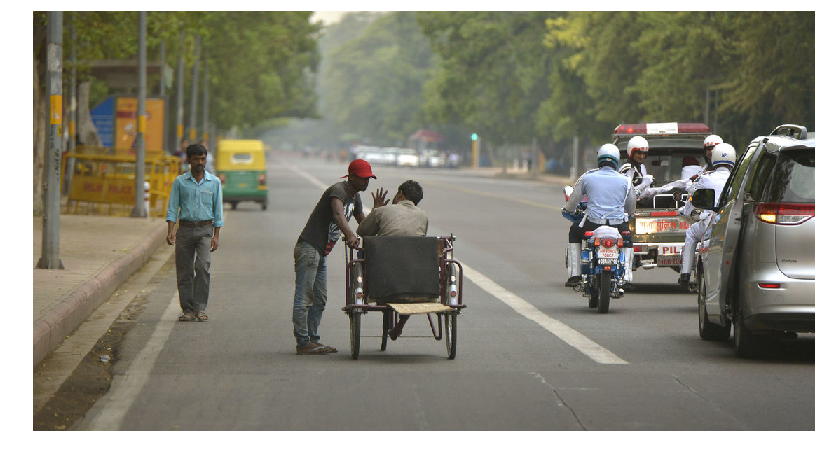

In [0]:
im  = cv2.imread('../DensePoseData/demo_data/demo_im.jpg')
plt.figure(figsize= [14,14])
plt.imshow(im[:,:,::-1]); plt.axis('off');plt.show()